In [0]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib inline
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# ! wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
# ! unzip -q MURA-v1.1.zip
! ls

MURA-v1.1  MURA-v1.1.zip  sample_data


In [0]:
train_df = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None, names=['FilePath'])
valid_df=pd.read_csv('MURA-v1.1/valid_image_paths.csv', header=None, names=['FilePath'])
train_labels_df=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', names=['FilePath', 'Labels'])
valid_labels_df=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', names=['FilePath', 'Labels'])

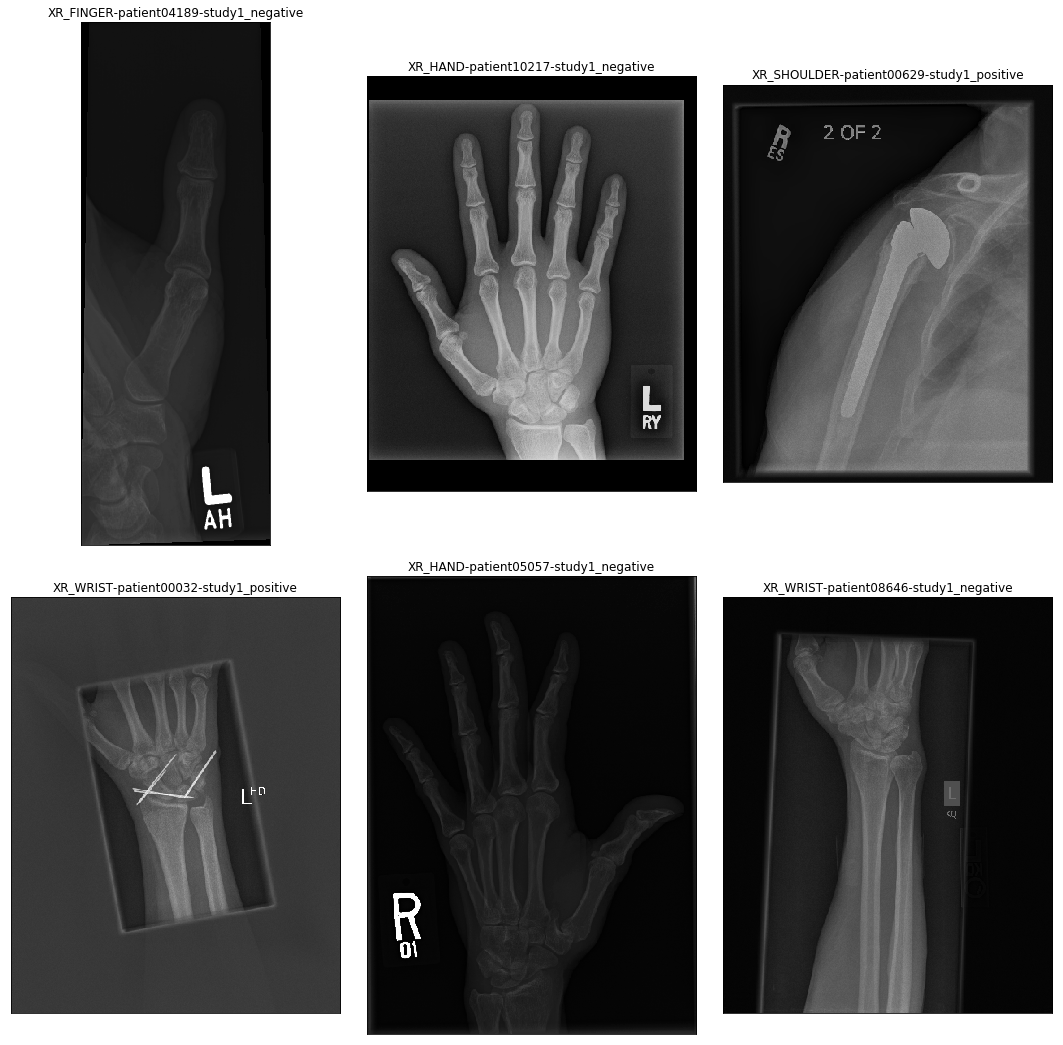

In [30]:
w, h = 10, 10
fig = plt.figure(figsize=(15, 15))
columns, rows = 3, 2
end, start = train_df.loc[0:].shape
ax = []
import random
for i in range(columns*rows):
    # img = np.array(Image.open(train_img_path.values[k][0]))
    k = random.randint(start, end)
    img = mpimg.imread((train_df.iloc[k,0]))
    title = (train_df.iloc[k,0]).split('/')
    title = title[2]+'-'+title[3]+'-'+title[4]
    k += 1
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title(title)  # set title
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.tight_layout(True)
plt.show()  # finally, render the plot

In [31]:
train_df['Label'] = train_df.apply(lambda x:1 if 'positive' in x.FilePath else 0, axis=1)
train_df['BodyPart'] = train_df.apply(lambda x: x.FilePath.split('/')[2][3:],axis=1)
train_df['StudyType'] = train_df.apply(lambda x: x.FilePath.split('/')[4][:6],axis=1)
valid_df['Label'] = valid_df.apply(lambda x:1 if 'positive' in x.FilePath else 0, axis=1)
valid_df['BodyPart'] = valid_df.apply(lambda x: x.FilePath.split('/')[2][3:],axis=1)
valid_df['StudyType'] = valid_df.apply(lambda x: x.FilePath.split('/')[4][:6],axis=1)
train_df.set_index(["FilePath", "BodyPart"]).count(level="BodyPart")

train_df.set_index(["FilePath", "Label"]).count(level="Label")

,BodyPart,StudyType
Label,,
0,21935,21935
1,14873,14873


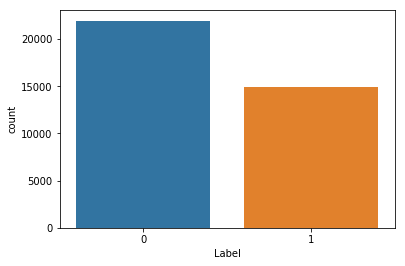

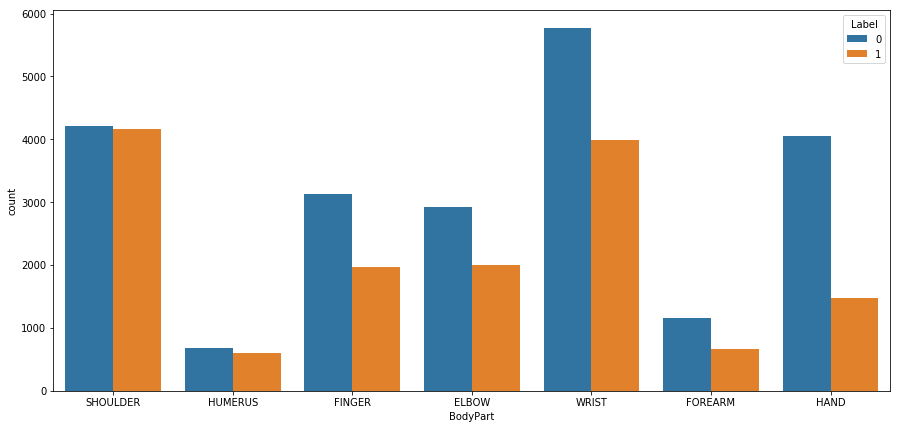

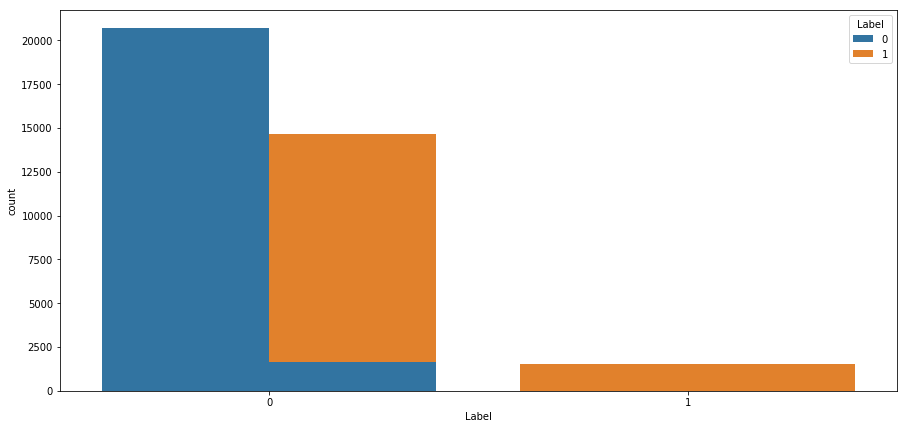

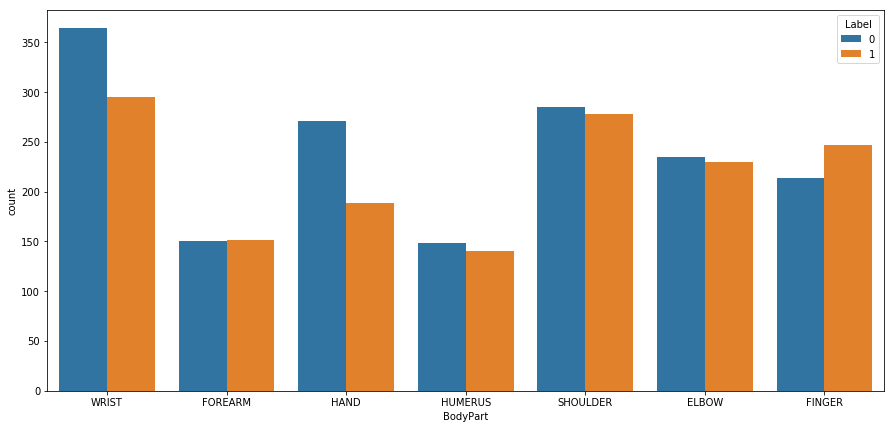

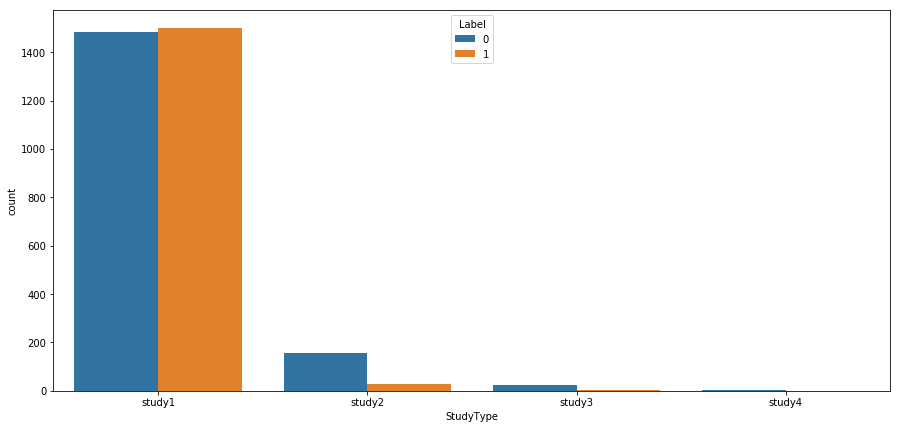

In [32]:
import seaborn as sns
sns.countplot(train_df['Label'])
plt.figure(figsize=(15,7))
sns.countplot(data=train_df,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=train_df,x='StudyType',hue='Label')

sns.countplot(valid_df['Label'])
plt.figure(figsize=(15,7))
sns.countplot(data=valid_df,x='BodyPart',hue='Label')
plt.figure(figsize=(15,7))
sns.countplot(data=valid_df,x='StudyType',hue='Label')

In [0]:
class MuraDataset(torch.utils.data.Dataset):
    
    def __init__(self,df,transform=None):
        self.df=df
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_name=self.df.iloc[idx,0]
        img=Image.open(img_name).convert('LA')
        # img=mpimg.imread(img_name)
        label=self.df.iloc[idx,1]
        # print (np.array(img).shape)

        if self.transform:
            img=self.transform(img)
        label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)
#         img = torch.stack(img)
        return img, label

# The paper uses the same standard deviation and mean as that of IMAGENET dataset
train_transform = transforms.Compose([
        transforms.Resize(224),
         transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])
val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])

train_dataset = MuraDataset(df=train_df,transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=0, shuffle=True)
val_dataset = MuraDataset(df=valid_df, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, num_workers=0, shuffle=True)

In [0]:
class PretrainedDensenet(nn.Module):
    def __init__(self, num_class=1):
        super().__init__()
        self.channels = 1664
        densenet_169 = models.densenet169(pretrained=True)
        for params in densenet_169.parameters():
            params.requires_grad_(False)
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=4)
        self.features = nn.Sequential(*list(densenet_169.features.children()))
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(self.channels, num_class)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        features = self.features(x)
        out = self.relu(features)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(-1, self.channels)
        return self.sigmoid(self.fc1(out))

In [0]:
def plotify(train_losses, val_losses):
    plt.plot(train_losses, label = 'Train Loss')
    plt.plot(test_losses, label = 'Test Loss')
    plt.show()

In [36]:
total_positive_images_train = (train_df.Label == 1).sum()
total_negative_images_train = (train_df.Label == 0).sum()
Wt1_train = total_negative_images_train/(total_negative_images_train + total_positive_images_train)
Wt0_train = total_positive_images_train/(total_negative_images_train + total_positive_images_train)

total_positive_images_valid = (valid_df.Label == 1).sum()
total_negative_images_valid = (valid_df.Label == 0).sum()
Wt1_valid = total_negative_images_valid/(total_negative_images_valid + total_positive_images_valid)
Wt0_valid = total_positive_images_valid/(total_negative_images_valid + total_positive_images_valid)

Wt = dict()
Wt_train={}
Wt_valid={}
Wt_train['Wt1'] = torch.from_numpy(np.asarray(Wt1_train)).double().type(torch.FloatTensor).to(device)
Wt_train['Wt0'] = torch.from_numpy(np.asarray(Wt0_train)).double().type(torch.FloatTensor).to(device)
Wt_valid['Wt1'] = torch.from_numpy(np.asarray(Wt1_valid)).double().type(torch.FloatTensor).to(device)
Wt_valid['Wt0'] = torch.from_numpy(np.asarray(Wt0_valid)).double().type(torch.FloatTensor).to(device)

Wt['train'] = Wt_train
Wt['valid'] = Wt_valid
Wt

{'train': {'Wt0': tensor(0.4041, device='cuda:0'),
  'Wt1': tensor(0.5959, device='cuda:0')},
 'valid': {'Wt0': tensor(0.4786, device='cuda:0'),
  'Wt1': tensor(0.5214, device='cuda:0')}}

In [0]:
# optimized weighted binary cross entropy loss
class Loss(nn.modules.Module):
    def __init__(self, Wt):
        super(Loss, self).__init__()
        self.Wt = Wt
        
    def forward(self, inputs, targets, cat):
        loss = -(self.Wt[cat]['Wt1'] * targets * inputs.log() + self.Wt[cat]['Wt0'] * (1 - targets) * (1 - inputs).log())
#         print (loss)
#         print (loss.sum())
        return loss.mean()

In [0]:
model = PretrainedDensenet()
# print(model.parameters())
criterion = Loss(Wt)
# criterion=nn.BCELoss()

# The network was trained end-to-end using Adam with default parameters β1 = 0.9 and β2 = 0.999 
optimizer = optim.Adam(model.parameters(), betas=(0.9,0.999), lr=0.0001)
# checking if cuda is available
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)

In [0]:
model.to(device)

In [0]:
def train(criterion, model, optimizer, n_epochs, device):
    import time
    import copy
    from tqdm import tqdm
    since = time.time()
    train_losses = []
    valid_losses = []
    model.to(device)
    valid_loss_min = np.Inf
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in tqdm(range(1, n_epochs+1)):
        print ('\n')
        print ("="*30)
        print (f'\nEpoch : {epoch}') 
        train_loss = 0.0
        valid_loss = 0.0
        running_corrects = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = Variable(images.to(device)), Variable(labels.to(device))
            # print (images.size(0))
            # print (labels.shape)
            labels = labels.view(-1,1)
            # print (labels.shape)
            optimizer.zero_grad()
            # print (images[0])
            outputs = model(images)
            # print (outputs)
            # outputs = torch.mean(outputs)
            # print (outputs)
            # print (labels)
            # print (outputs.shape)
            # _, preds = torch.max(outputs, 1)
            # loss = criterion(outputs, labels)
            loss = criterion(outputs, labels, cat='train')
            # print (loss)
            
            loss.backward()
            optimizer.step()
            # print (loss)
            train_loss += loss.item()*images.size(0)
            # print (loss.item())
            # running_corrects += torch.sum(preds == labels.data)
            # break
        else:
            with torch.no_grad():
                model.eval()
                for images, labels in val_loader:
                    images, labels = Variable(images.to(device)), Variable(labels.to(device))
                    # images, labels = images.to(device), labels.to(device)
                    labels = labels.view(-1,1)

                    output = model(images)

                    # loss = criterion(output, labels)
                    loss = criterion(output, labels, cat='valid')

                    valid_loss += loss.item()*images.size(0)
        train_loss = train_loss/len(train_loader.sampler)
        train_losses.append(train_loss)
        valid_loss = valid_loss/len(val_loader.sampler)
        valid_losses.append(valid_loss)
        print (f"\nTraining Loss : {train_loss} \nValidation Loss : {valid_loss}")

        if valid_loss < valid_loss_min:
            print (f"Validation Loss decreased from {valid_loss} to  {valid_loss_min} ....Saving model")
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    model.load_state_dict(best_model_wts)
    plotify(train_losses, valid_losses)
    return model


  0%|          | 0/5 [00:00<?, ?it/s]




Epoch : 1



 20%|██        | 1/5 [28:32<1:54:10, 1712.63s/it]


Training Loss : 0.3160654413158597 
Validation Loss : 0.31979051582843837
Validation Loss decreased from 0.31979051582843837 to  inf ....Saving model



Epoch : 2



Training Loss : 0.30369718556778763 
Validation Loss : 0.30672113891501035
Validation Loss decreased from 0.30672113891501035 to  0.31979051582843837 ....Saving model


 40%|████      | 2/5 [56:54<1:25:28, 1709.54s/it]




Epoch : 3



 60%|██████    | 3/5 [1:25:32<57:03, 1711.89s/it]


Training Loss : 0.2990178715383403 
Validation Loss : 0.31689365322343027



Epoch : 4



 80%|████████  | 4/5 [1:54:10<28:33, 1713.74s/it]


Training Loss : 0.29530356982769435 
Validation Loss : 0.2981885042942275
Validation Loss decreased from 0.2981885042942275 to  0.30672113891501035 ....Saving model



Epoch : 5



100%|██████████| 5/5 [2:22:44<00:00, 1713.87s/it]


Training Loss : 0.29367865121343867 
Validation Loss : 0.2955091858435915
Validation Loss decreased from 0.2955091858435915 to  0.2981885042942275 ....Saving model


Training complete in 142m 45s


NameError: ignored

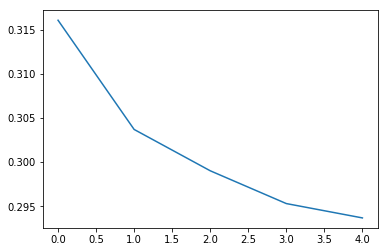

In [40]:
model_ft = train(criterion=criterion,optimizer=optimizer, model=model, n_epochs=5, device=device)